In [ ]:
import pandas as pd
import nltk as nltk
from nltk.corpus import stopwords
import numpy as np
from pathlib import Path
import itertools as it

import matplotlib.pyplot as plt


### Load Data

Come primo step carichiamo il file di annotazioni fornito.

In [ ]:
defs_df = pd.read_csv(Path("data/definitions.csv"), sep=";")

# extract elements from level#1_level#2_concept col names
old_col_names = defs_df.columns
new_col_names = ["_".join(name.split("_")[0:2]) for name in old_col_names] 
concept_names = [name.split("_")[-1] for name in old_col_names]

defs_df.columns = new_col_names

In [ ]:
old_col_names

Index(['concreto_generico_building', 'concreto_specifico_molecule',
       'astratto_generico_freedom', 'astratto_specifico_compassion'],
      dtype='object')

Visualizziamo le prime 10 definizioni per i 4 concetti:
* *Building* (concreto-generico)
* *Molecule* (concreto-specifico)
* *Freedom* (astratto-generico)
* *Compassion* (astratto-specifico)

In [ ]:
defs_df.head(10)

,concreto_generico,concreto_specifico,astratto_generico,astratto_specifico
0,concrete structure typically made with cement,A chemistry term that describes the smallest p...,unconditional choice,comprehension
1,structure that hasa walls and roof,group of atoms,without constrains,be sensitive and understandable towards a person
2,"Human artifact dedicated to various purposes, ...",Chemical component formed by combinations of a...,The lack of physical or mental constraints.,The ability to experience other people's negat...
3,a construction where you can live inside,"set of atoms, that is components of which ever...","live without constrains, a state of mind",sympathetic attitude
4,structure where people can stay,"invisible thing , everything is made of it",conceptual idea where no one can limitate othe...,undterstand the suffering and feel sad for it
5,A construction made for living or decorative p...,a specific element that composes things,possibility to make decisions,sad feeling towards someone
6,Architectural structure with one or more level...,One of the smallest sub-structures of matter; ...,The ability of one to make free choices and ac...,The ability of one to make free choices and ac...
7,object built with material,invisible particle,autonomy to do something,understanding a bad situation
8,An architectural structure,Amount of substance,a state of autonomy,Understand the mood of others
9,a structure consisting of walls and foundation...,the smallest amount of matter,"possibility to move, think independently",understand a bad situation and take action to ...


Come già descritto in precedenza, l'obiettivo principale dell'esercitazione è quantificare la **difficoltà** di definizione di concetti, valutandola attraverso la **variabilità** delle definizioni date da 20 annotatori.

Per portare a termine il task necessitiamo dunque di valutare la **similarità** delle differenti definizioni per ciascun concetto. La pipeline si articola nei seguenti step principali:

1. Scelta della rappresentazione computazionale delle definizioni
2. Preprocessing
3. Calcolo della **similarità media** tra tutte le possibili **combinazioni di coppie** di definizioni
4. Visualizzazione dei risultati

Seguendo la pipeline appena descritta, verranno utilizzate due metodologie differenti:
* Rappresentazione bag-of-words e funzione di similarità basata su overlap:

$$ \operatorname{sim}(D_1, D_2) = \frac{|d_1 \cap d_2|}{\min(|d_1|, |d_2|)} $$

* Rappresentazione vettoriale e cosine similarity

$$ \operatorname{sim}(\mathbf{d_1}, \mathbf{d_2}) = \frac{\mathbf{d_1}\cdot\mathbf{d_2}}{||\mathbf{d_1}||||\mathbf{d_2}||} $$

dove $D_1, D_2$ e $\mathbf{d_1}, \mathbf{d_2}$ rappresentano rispettivamente due definizioni in forma bag-of-word e vettoriale.


In [ ]:
def preprocess(definition):

    # Tokenization
    definition = definition.lower()
    tokens = set(nltk.word_tokenize(definition))

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    punct = {',', ';', '(', ')', '{', '}', ':', '?', '!', '.', "'s"}    
    tokens = tokens.difference((stop_words.union(punct)))

    # Lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = set(lemmatizer.lemmatize(token) for token in tokens)

    return lemmatized_tokens


def overlap_similarity(bow1, bow2):
    return len(bow1 & bow2) / min(len(bow1), len(bow2))


def concept_matrix_similarity(definitions, preprocess_func, sim_func):
    defs_df = definitions.copy()
    avg_scores = {}

    for col in defs_df.columns:
        # apply preprocessing function
        defs_df[col] = defs_df.apply(lambda x: preprocess_func(x[col]), axis=1)
        # compute similarites for every definitions combinations pairs
        sim_scores = np.array([sim_func(def1,def2) for def1, def2 in it.combinations(defs_df[col], 2)])
        # compute avg similarity
        avg_scores[col] = sim_scores.mean()
    
    return avg_scores, np.array(list(avg_scores.values())).reshape((2,2))


def plot_matrix(scores, ax, title):
    print(scores)
    col_labels = ['Generico', 'Specifico']
    row_labels = ['Concreto', 'Astratto']
    line_color = '#2143c2'
    text_color = '#292d33'
    
    ax.set_title(title, color=text_color)

    ax.imshow(np.ones((2,2)), cmap='binary')  

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(col_labels, fontsize='large', color=text_color)
    ax.set_yticklabels(row_labels, fontsize='large', color=text_color)

    ax.spines[['top','bottom','right','left']].set_color(line_color)
    ax.spines[['top','bottom','right','left']].set_linewidth(1.8)
    ax.spines[['top','bottom','right','left']].set_alpha(0.85)

    ax.axvline(0.5, color=line_color, alpha=0.35)
    ax.axhline(0.5, color=line_color, alpha=0.35)
    for i in range(2):
        for j in range(2):
            ax.text(j,i, f"{scores[i,j]:10.4f}", 
                        ha="center", va="center",
                        fontsize='medium',
                        color=text_color)

[[0.26417432 0.1625731 ]
 [0.08401559 0.08469786]]


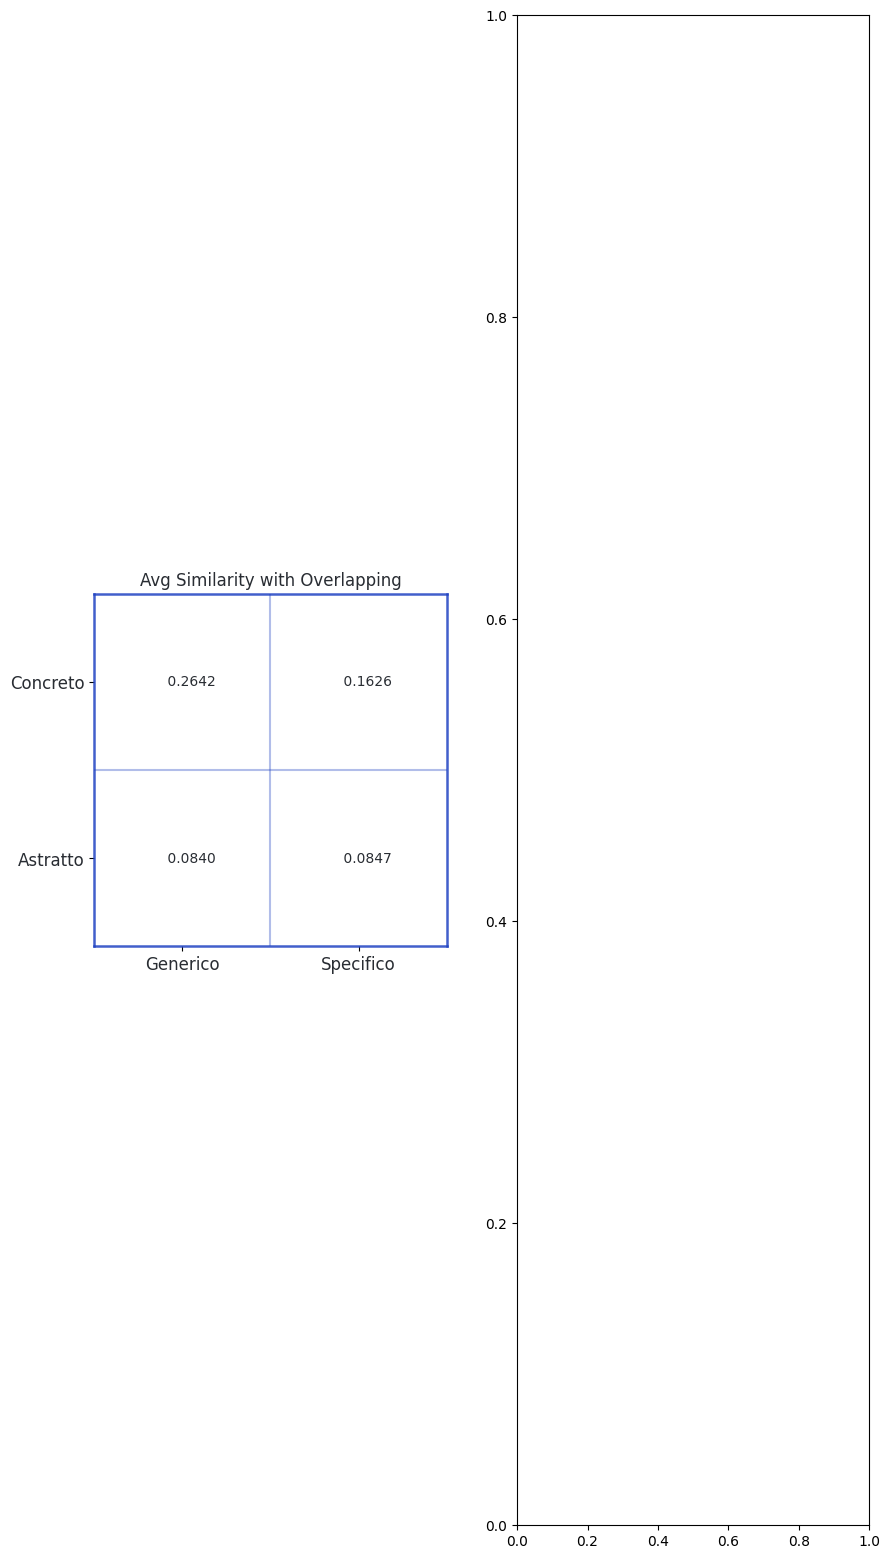

In [ ]:
_, avg_scores = concept_matrix_similarity(defs_df.copy(), preprocess, overlap_similarity)

fig, axes = plt.subplots(1,2,figsize=(10,20), dpi=100)
plot_matrix(avg_scores, axes[0], "Avg Similarity with Overlapping")

### Vector Space Model

In [ ]:
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
def vsm_preprocess(definition, vectorizer):
    return vectorizer.transform([definition])


def concept_matrix_similarity_vsm(definitions, preprocess_func, sim_func):
    defs_df = definitions.copy()
    avg_scores = {}

    for col in defs_df.columns:
        # per-concept vectorization 
        vectorizer = CountVectorizer(analyzer='word', stop_words='english').fit(defs_df[col])
        # apply preprocessing function
        defs_df[col] = defs_df.apply(lambda x: preprocess_func(x[col], vectorizer), axis=1)
        # compute similarites for every definitions combinations pairs
        sim_scores = np.array([sim_func(def1,def2) for def1, def2 in it.combinations(defs_df[col], 2)])
        # compute avg similarity
        avg_scores[col] = sim_scores.mean()
    
    return avg_scores, np.array(list(avg_scores.values())).reshape((2,2))


In [ ]:


_, avg_scores = concept_matrix_similarity_vsm(defs_df.copy(), vsm_preprocess, cosine_similarity)
plot_matrix(avg_scores, axes[1], "avg similarity with cosine similarity")

[[0.18829939 0.08760498]
 [0.063414   0.06817438]]


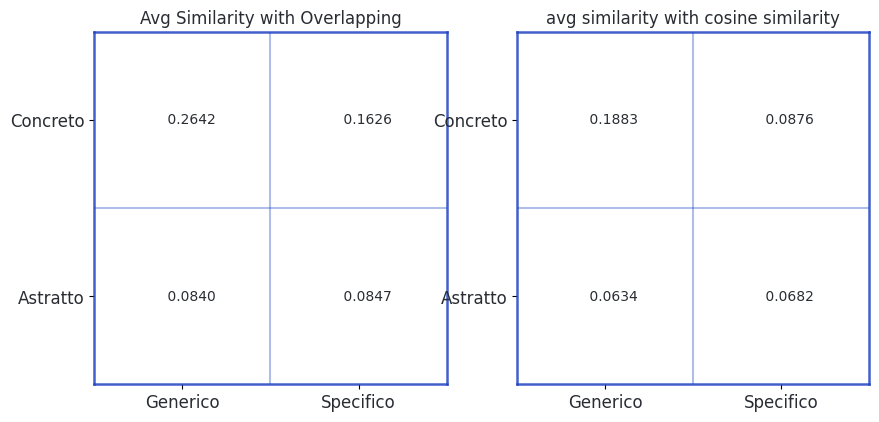

In [ ]:
fig

## Risultati

Dall'analisi dei due plot emoergono due importanti dinamiche sui valori ottenuti:

* I valori di similarità calano nettamente passando dall concetto concreto rispetto a quello astratto. Altrettanto non si può dire passando dal concetto generico a quello specifico, in cui la similarità medi si riduce meno drasticamente.

* I valori di similarità nel secondo caso con l'utilizzo del VSM si riducono sensibilmente. Da un'analisi della matrice terms-document emerge come lo spazio sia altamente sparso su un numero così ridotto di campioni. 

Particolare attenzione bisogna porre alla generalizzazione di questi risultati, in quanto l'intera analisi è stata svolta su un piccolissimo campione, tale da non essere statiticamente rilevante! 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afb22156-bb61-4d65-847d-18db79c0d4d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>